In [48]:
# Import section
import os
import sys
import cv2
import math
import json
import pickle
import shutil
import torch
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML
from matplotlib import animation
from matplotlib import pyplot as plt
from queue import Queue
from threading import Thread
from IPython.utils import io
from collections import namedtuple
from types import ModuleType, FunctionType
from gc import get_referents

# Custom detector
!git clone https://github.com/neopoleones/FootAndBall.git
sys.path.insert(0, 'FootAndBall')
import detector as fbd

sns.set_theme('paper')
sns.set_style('whitegrid')


# Setup logger

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s:%(message)s')

fatal: destination path 'FootAndBall' already exists and is not an empty directory.


In [49]:
# Constants Section
default_dpi = 120
fbd_weights = 'FootAndBall/models/model_20201019_1416_final.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using: {device}')

Using: cuda


In [50]:
Coordinates = namedtuple('Coordinates', ['xmin', 'ymin', 'xmax', 'ymax'])

def plot_boxes(ax, detection):
    return ax.plot(
            [detection.xmin, detection.xmax, detection.xmax, detection.xmin, detection.xmin],
            [detection.ymin, detection.ymin, detection.ymax, detection.ymax, detection.ymin],
            color='red'
    )

# Helper functions
def get_frames(video_capture, t):
    action_frames = []
    action_time = round(t * 1000)
    
    # GET FPS
    fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    
    # Set offset via "POSITION MSEC" property
    video_capture.set(cv2.CAP_PROP_POS_MSEC, action_time)
    
    # Scan for frames
    for i in range(fps + 1):
        ok, curr_frame = video_capture.read()
        if ok:
            action_frames.append(curr_frame)
    return np.array(action_frames)


# Creates a gif from video frames. To display use 
def get_action_gif(video_frames, vid_caption = 'Action: default', ds_dpi = default_dpi, det = None):
    fig, ax = plt.subplots(1, 1)
    fig.suptitle(vid_caption, fontsize=12)
    
    video = np.array(video_frames)
    im = plt.imshow(video[0,:,:,:])

    plt.gcf().set_dpi(default_dpi)
    plt.tight_layout()
    plt.close()
    
    if det:
        detection = det[0]
        p = plot_boxes(ax, detection)
    
    def init():
        im.set_data(video[0,:,:,:])
    
    def animate(i):
        im.set_data(video[i,:,:,:])
        if det:
            curr_det = det[i]
            for line in ax.get_lines():
                line.remove()
                
            for _, detection in curr_det.iterrows():
                plot_boxes(ax, detection)
                
        return im
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
    return anim.to_html5_video()


def gen_caption(gshot):
    return f'{gshot.event} with {gshot.event_info}'


# By so@velimir-mlaker, for debug(oom) purposes
BLACKLIST = type, ModuleType, FunctionType
def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size


def plot_detection(frame, detections_pd, ds_dpi = default_dpi):
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    plt.gcf().set_dpi(default_dpi)
    fig.suptitle('Detection plot')
    ax.imshow(frame)
    
    # Iterate over detections
    for idx, detection in detections_pd.iterrows():
        plot_boxes(ax, detection)
    
    plt.tight_layout()
    return ax


def extract_socccer_players(frame, detection_results):
    soccers = []
    coordinates = []
    
    for idx, detection in detection_results.iterrows():
        
        # 0 is "human" class
        if detection['class'] == 0:
            xmin, xmax, ymin, ymax = round(detection.xmin), round(detection.xmax), round(detection.ymin), round(detection.ymax)
            soccers.append(frame[ymin:ymax, xmin:xmax])
            coordinates.append(Coordinates(xmin, ymin, xmax, ymax))
    return soccers, coordinates


# title - shape(size) of image
def plot_soccers(soccers):
    dim = math.ceil(math.sqrt(len(soccers)))
    
    fig, axs = plt.subplots(dim, dim, figsize=(12, 12))
    [ax.set_axis_off() for ax in axs.ravel()]
    plt.gcf().set_dpi(default_dpi)
    
    fig.suptitle('Soccers')
    for i, soccer in enumerate(soccers):
        axs.flat[i].set_title(f's_{soccer.shape}')
        axs.flat[i].imshow(soccer)
    
    plt.tight_layout()
    plt.show()

# returns center x/y
def to_center(c: Coordinates):
    return (c.xmin + (c.xmax - c.xmin) // 2, c.ymin + (c.ymax - c.ymin) // 2)

# c1_2 - center coordinates in format (x,y)
def abs_dist(c1, c2):
    return abs(math.hypot(c1[0] - c2[0], c1[1] - c2[1]))

In [61]:
GameShot = namedtuple('GameShot', ['time', 'event', 'event_info'])


# Returns detector and output adapter (for compatibility) 
# Adapter creates a pandas DF from output (Columns: xmin ymin xmax ymax confidence name)

# Give additional context (enlarging boxes)
def adapter_yolov5(output, delta = 12):
    pandas_representation = output.pandas().xyxy[0]
    pandas_representation.xmin -= delta
    pandas_representation.ymin -= delta
    pandas_representation.xmax += delta
    pandas_representation.ymax += delta
    return pandas_representation

def detector_yolov5():
    model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')
    return model, adapter_yolov5 


def footandball_adapter(output):
    boxes, labels, scores = output.values()
    
    # TODO: push to github
    return pd.DataFrame({
        'xmin': boxes[:, 0].cpu(),
        'ymin': boxes[:, 1].cpu(),
        'xmax': boxes[:, 2].cpu(),
        'ymax': boxes[:, 3].cpu(),
        'confidence': scores.cpu(),
        'class': (labels - 2).cpu()
    })

def detector_footandball():
    cfg = fbd.DetectorCfg(fbd_weights, dev = device)
    model = mod = fbd.FBPDetectorModel(cfg)
    return model, footandball_adapter


class DFIVideoLoader:    
    
    # Takes id of video. e_sz - extracted image size, force - delete all saved assets
    def __init__(self, id, provide_detector, path = '../input/dfl-bundesliga-data-shootout', work_path = 'out/', n_threads = 2, force=True, e_sz = 20, dbg = False):
        logging.info('Initializing VideoLoader')
        
        # Firstly, load event data
        self.frames = [] #TODO: delete me
        self.results = []
        
        self.id = id     
        self.dbg = dbg
        self.e_sz = e_sz
        video_path = path + '/train/' + id + '.mp4'
        self.events_data = pd.read_csv(path + '/train.csv').groupby(['video_id']).get_group(id)
        
        # Create directory for dataset
        self.work_path = work_path + id
        if force:
            try:
                shutil.rmtree(work_path)
            except: pass
            
        if not os.path.exists(self.work_path):
            os.makedirs(self.work_path)
        
        # Get detector
        self.detector, self.adapter = provide_detector()
        
        # Extract all frames with N threads
        self.extract_q = Queue()
        for idx, event_row in list(self.events_data.iterrows())[994:995]:
            self.extract_q.put(GameShot(event_row.time, event_row.event, event_row.event_attributes))
        
        captures = []
        for th in range(n_threads):
            th_video_capture = cv2.VideoCapture(video_path) # cv2 isn't thread safe?
            captures.append(th_video_capture)
            
            new_worker = Thread(target=self.extract_frames, args=(th_video_capture, ))
            new_worker.daemon = True
            new_worker.start()
            
        
        # Wait for threads
        self.extract_q.join()
        for cap in captures:
            cap.release()     # We don't need oom, right??
            
        logging.info(f'Extracted all frames: used {n_threads} threads')
        
    def extract_frames(self, vc):
        i = 0
        while True:
            gshot = self.extract_q.get()
            logging.info(f'Extracting frames at {gshot.time}')
            frames = get_frames(vc, gshot.time)
            
            self.handle_frames(frames, gshot)
            self.extract_q.task_done()
    
    def handle_frames(self, frames, gshot):
        logging.info(f'[verbose] working with frames/detections of short_{gshot.time}')
        self.saved = []
        
        for frame_n, frame in enumerate(frames):
            ball_cfd = 0.0
            ball_loc = (-1, -1)
            
            dets = self.adapter(self.detector(frame, size=1920))
            
            if self.dbg:
                self.frames.append(frame)
                self.results.append(dets)
                
                
            # Get center coordinates of ball
            for _, detection in dets.iterrows():
                if detection['class'] == 32:
                    if detection.confidence > ball_cfd:
                        ball_cfd = detection.confidence
                        ball_loc = Coordinates(detection.xmin, detection.ymin, detection.xmax, detection.ymax)
                        logging.info(f'Next ball{ball_loc}: confidence: {detection.confidence}')
                    
            if ball_cfd != 0:
                best_coordinates = None
                min_dist = sys.maxsize - 1
                
                _, coordinates_list = extract_socccer_players(frame, dets)
                for soccer_coordinates in coordinates_list:
                    soccer_center = to_center(soccer_coordinates)
                    dst = abs_dist(to_center(ball_loc), soccer_center)
                    
                    if dst < min_dist:
                        min_dist = dst
                        best_coordinates = soccer_coordinates
                
                ext_part = frame[
                    min(int(ball_loc.ymin), int(best_coordinates.ymin)):max(int(ball_loc.ymax), int(best_coordinates.ymax)),
                    min(int(ball_loc.xmin), int(best_coordinates.xmin)):max(int(ball_loc.xmax), int(best_coordinates.xmax))
                ]
                self.saved.append(ext_part)

ds = DFIVideoLoader('1606b0e6_0', detector_yolov5, dbg = False)

[2022-08-30 17:36:32,997] INFO:Initializing VideoLoader
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
[2022-08-30 17:36:33,315] INFO:YOLOv5 🚀 2022-8-30 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)



Exception: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.61 GiB already allocated; 20.75 MiB free; 14.89 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF. Cache may be out of date, try `force_reload=True` or see https://github.com/ultralytics/yolov5/issues/36 for help.

In [52]:
#frame, result = ds.frames[0], ds.results[0]
#soccers, coordinates = extract_socccer_players(frame, result)

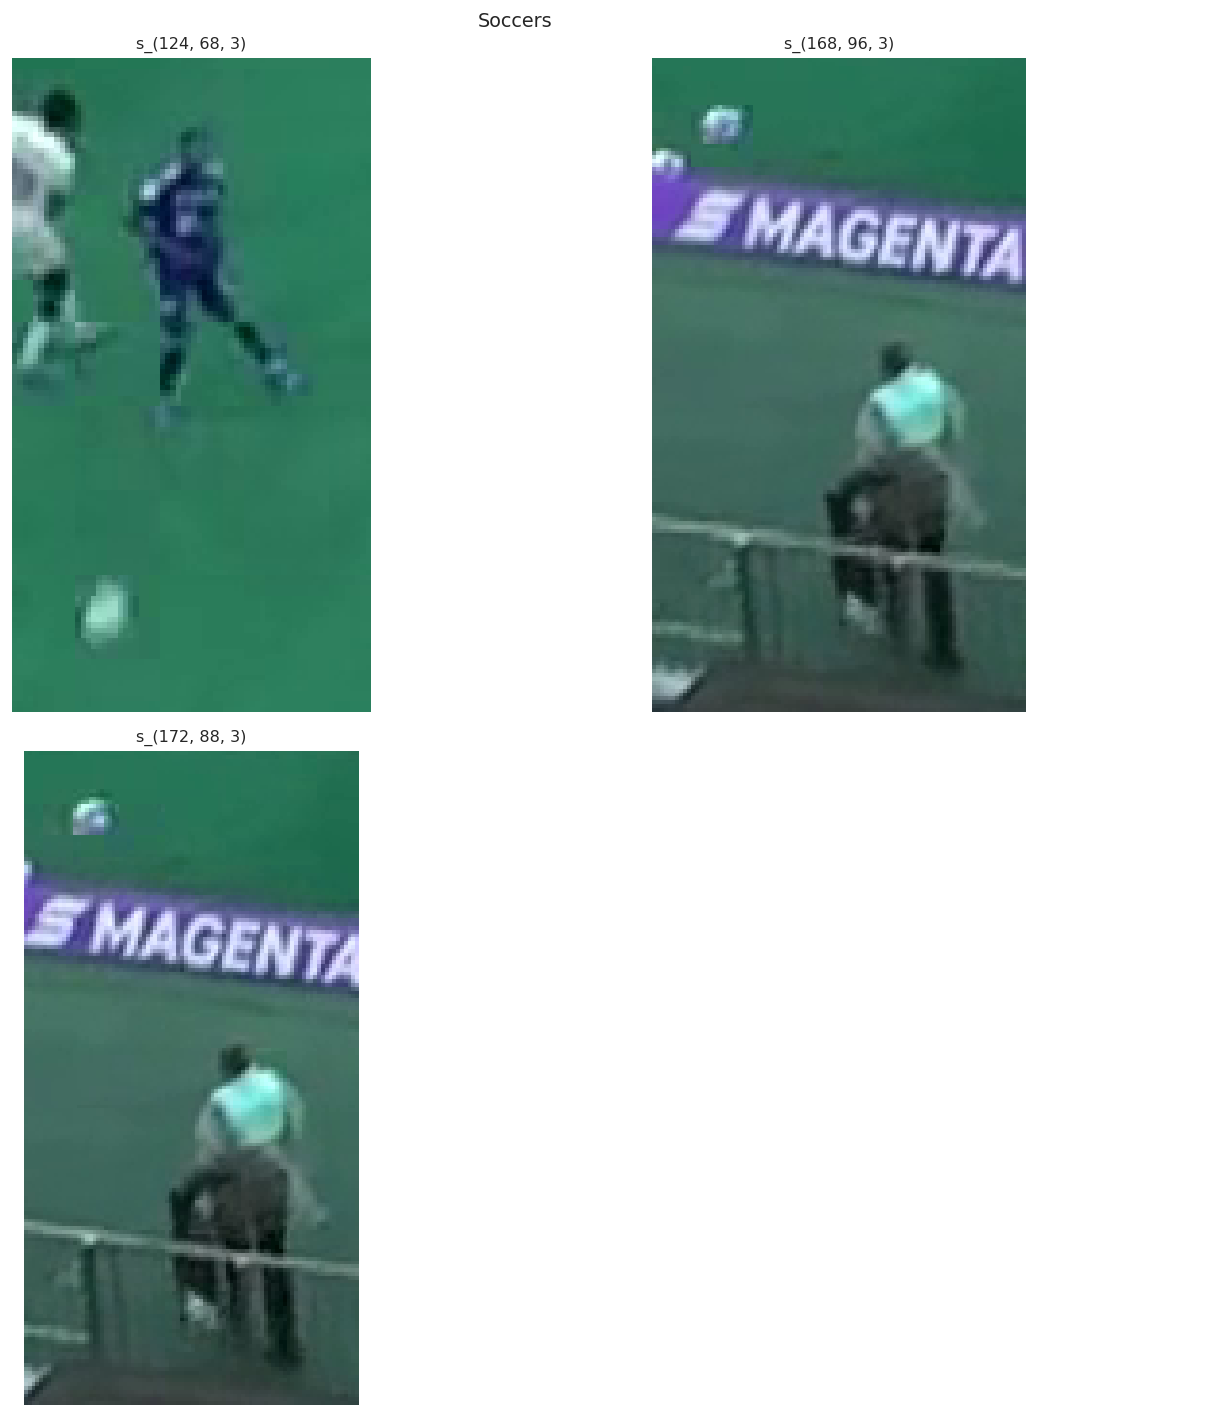

In [60]:
plot_soccers(ds.saved)

In [ ]:
#%config InlineBackend.figure_format = 'retina'
#fig, ax = plt.subplots(figsize = (16, 8))

#center_point = to_center(coordinates[0])
#ax.imshow(frame)
#ax.scatter(center_point[0], center_point[1], color = 'red')

In [ ]:
#%matplotlib inline
#plot_soccers(soccers)

In [ ]:
#%matplotlib inline
HTML(get_action_gif(ds.frames, det = ds.results))

In [58]:
ds.events_data

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']
...,...,...,...,...
995,1606b0e6_0,3000.870000,play,"['pass', 'freekick']"
996,1606b0e6_0,3002.103519,end,NaN
997,1606b0e6_0,3012.231795,start,NaN
998,1606b0e6_0,3013.230000,play,"['pass', 'openplay']"
